In [4]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.util import get_dataset, get_xy, get_r_squared, split, to_data_matrix
from sgpi.plot import *

from sgpi import model
from sgpi.learner import SGRegressionLearner

import pandas as pd
import pysgpp as sg; sg.omp_set_num_threads(4)

from fractions import Fraction
from mpl_toolkits.mplot3d import Axes3D

In [8]:
def inverse_parabola(x, y):
    z = 16*x*(1-x)*y*(1-y)
    return z

def get_data(num=100):
    np.random.seed(42)
    x = np.linspace(0, 1, num)
    y = x
    z = inverse_parabola(x,y) 
    return x, y, z

def get_data_from_grid(grid):
    storage = grid.getStorage()
    coords = [None] * grid.getSize()
    for i in range(0, grid.getSize()):
        p = storage.get(i)
        coords[i] = (p.getCoord(0), p.getCoord(1))    
    x, y = zip(*coords)
    z = inverse_parabola(np.array(x), np.array(y))
    X = np.vstack((x,y)).T
    return X, z

def plot_surface(ax):
    x,y,_ = get_data(num=300)
    x, y = np.meshgrid(x, y)
    z = inverse_parabola(x,y)
    print z.shape, x.shape
    ax.plot_surface(x,y,z, cmap='viridis', vmin=0.0, vmax=0.8)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$y$')    

def plot_contour(ax):
    x,y,_ = get_data(num=100)
    x, y = np.meshgrid(x, y)
    z = inverse_parabola(x,y)
    c = ax.contour(x,y,z)
    plt.clabel(c, inline=1, fontsize=10)
    ax

In [6]:
x,y,z = get_data(num=100)
X = np.vstack((x,y)).T

(100,) (100,)


(300, 300) (300, 300)


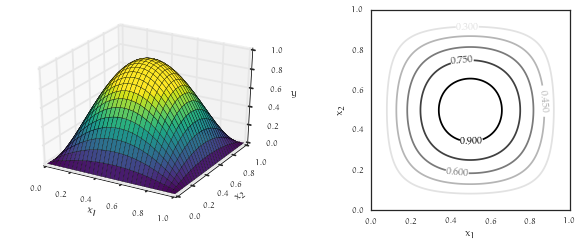

In [9]:
fig = plt.figure(figsize=plt.figaspect(0.333))

ax3d = fig.add_subplot(1, 2, 1, projection='3d')
ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect(1)

plot_surface(ax3d)
plot_contour(ax)

fig.savefig("../writing/thesis/figures/parabola_contour.pdf", bbox='tight', bbox_inches='tight')

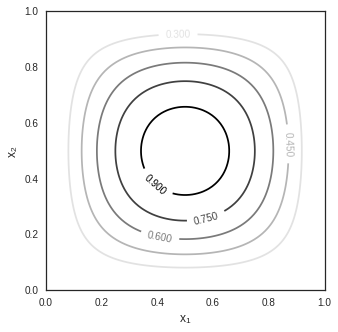

In [168]:
fig, ax = plt.subplots(figsize=(5,5))
plot_contour(ax)
fig.savefig("../writing/thesis/figures/parabola_contour.pdf", bbox='tight')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

In [23]:
level = 3
T = 0.0
grid_config = model.GridConfig(type=sg.GridType_Linear, level=level, T=T) # use standard linear basis
adaptivity_config = model.AdaptivityConfig(num_refinements=0, no_points=0, treshold=0.0, percent=0.0)
reg_type = sg.RegularizationType_Diagonal
solv_type = sg.SLESolverType_CG

solver_config = model.SolverConfig(type=solv_type, max_iterations=1000, epsilon=0, threshold=0)
final_solver_config = solver_config

regularization_config = model.RegularizationConfig(type=reg_type, exponent_base=1, lambda_reg=0.0, l1_ratio=1.0)

estimator = SGRegressionLearner(grid_config, regularization_config, solver_config,
                                final_solver_config, adaptivity_config)

In [24]:
grid = sg.Grid.createLinearGrid(2)
gen = grid.getGenerator()
gen.regular(level, T)

X, z = get_data_from_grid(grid)
grid.getSize()

17

In [25]:
estimator.fit(X, z)
print -estimator.score(X,z)

3.62527989532e-33


In [19]:
def get_grid_points(grid, weights):
    storage = grid.getStorage()
    indices = []
    for i in range(0, grid.getSize()):
        index = storage.get(i)
        x_pos = index.getCoord(0)
        y_pos = index.getCoord(1)
        prior = weights[i]
        indices.append( (x_pos,y_pos, prior) )
    return indices

def plot_diagonal(grid, weights):
    indices = get_grid_points(grid, weights)
    df = pd.DataFrame(indices, columns=['x', 'y', 'prior'])
    
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_axis_off()
    ax.set(adjustable='box-forced', aspect='equal')
    for name, group in df.groupby('prior'):
        ax.plot(group['x'], group['y'], label=Fraction(name), linewidth=0, marker='$ {0:.4f} $'.format(name),
                markersize=40)
    return fig, ax

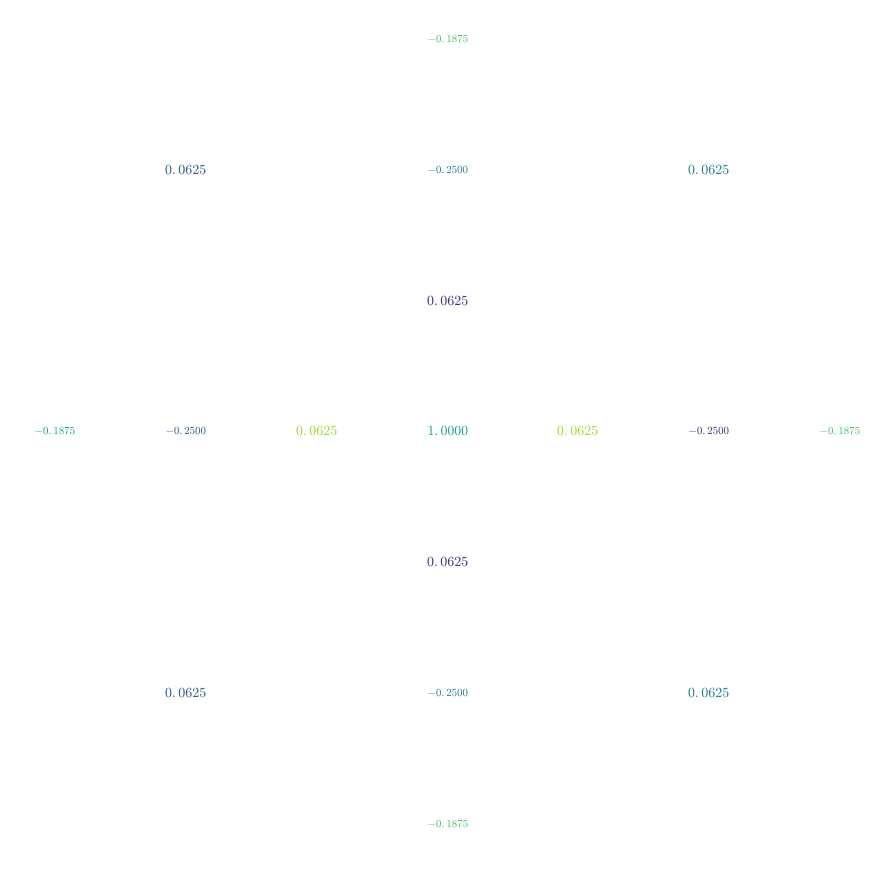

In [20]:
grid = estimator._learner.getGrid()
weights = estimator.get_weights()
fig, ax = plot_diagonal(grid, weights)

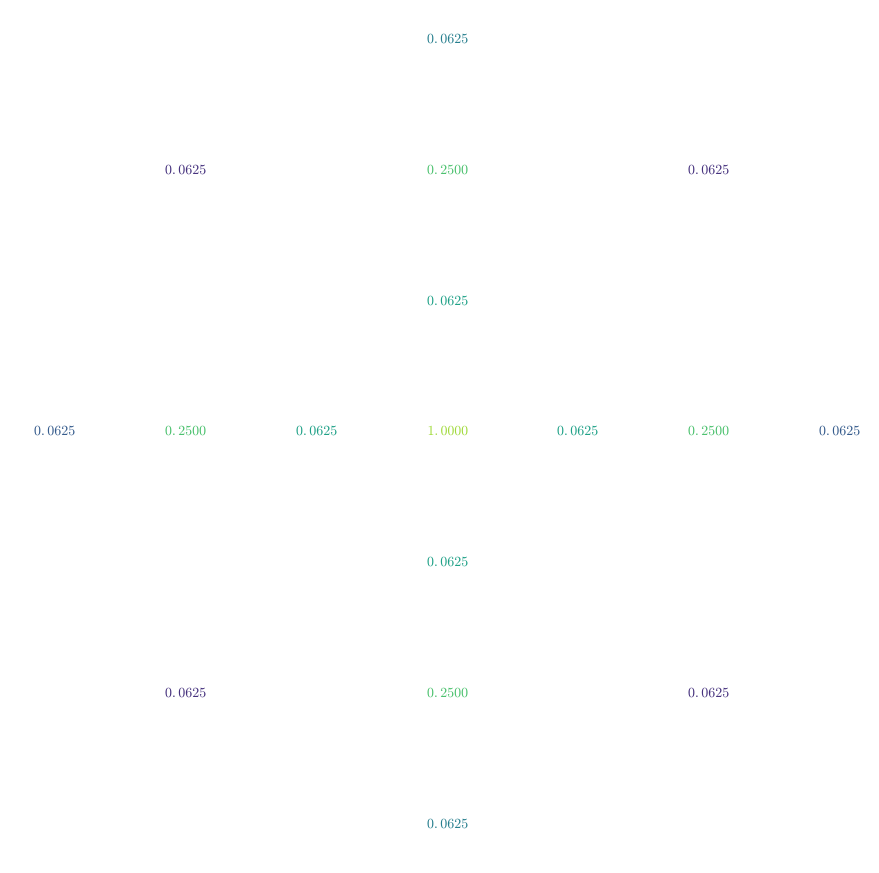

In [26]:
grid = estimator._learner.getGrid()
weights = estimator.get_weights()
fig, ax = plot_diagonal(grid, weights)

In [21]:
weights

array([ 1.    , -0.25  , -0.25  , -0.1875,  0.0625,  0.0625, -0.1875,
       -0.25  , -0.25  , -0.1875,  0.0625,  0.0625, -0.1875,  0.0625,
        0.0625,  0.0625,  0.0625])